<a href="https://colab.research.google.com/github/kangdoung/Deep_Learning/blob/main/Inception_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Step 01: SETUP ENVIRONMENT


##Check Colab GPU Information

In [ ]:
!nvidia-smi

Wed Nov  4 16:49:28 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

##Install libraries



In [ ]:
#Import libraries are used in this project
from __future__ import absolute_import, division, print_function

#Authentication and download file from Google Drive
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

import os
from os import path

import zipfile                 #Extract zip file
import json                    #Read json 
  
import numpy as np             #linear algebra
import pandas as pd            #dataset progressing, CSV file 
import argparse                
import random
from scipy import misc
from skimage import draw

from sklearn.model_selection import train_test_split             # Used for split train & val dataset
from sklearn.metrics import roc_auc_score,accuracy_score

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.nn import Module
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch import optim

import torchvision.transforms as transforms
import torchvision

from fastprogress import master_bar, progress_bar


import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.image as mpimg                                
from PIL import Image
import cv2
import time

print('Importing... done!')

Importing... done!


## Set hyperparamaters

In [ ]:
IMAGE_SIZE = 299                   # Image size (224x224)
IMAGENET_MEAN = [0.485, 0.456, 0.406]         # Mean of ImageNet dataset (used for normalization)
IMAGENET_STD = [0.229, 0.224, 0.225]          # Std of ImageNet dataset (used for normalization)
BATCH_SIZE = 8                         
LEARNING_RATE = 0.0001
LEARNING_RATE_SCHEDULE_FACTOR = 0.1           # Parameter used for reducing learning rate
LEARNING_RATE_SCHEDULE_PATIENCE = 5           # Parameter used for reducing learning rate
MAX_EPOCHS = 100                              # Maximum number of training epochs
TRAINING_TIME_OUT=3600*10

#Step 02: RETINAL DISEASE DATASET

##Download dataset

In [ ]:
#Restore all data from Google Drive to virtual Colab machine with File ID
zip_id = '1Nl4rhnP_22dJc_mbWvc4mv3e9Kmsv5JU' 
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

print ("retinal_disease_classificaton.zip ...")
myzip = drive.CreateFile({'id': zip_id})
myzip.GetContentFile('retinal_disease_classificaton.zip')

print ("retinal_disease_classificaton.zip ...")
if not os.path.exists('retina_dataset'):
    os.makedirs('retina_dataset')
zip_ref = zipfile.ZipFile('retinal_disease_classificaton.zip', 'r')
zip_ref.extractall('retina_dataset')
zip_ref.close()
os.remove("retinal_disease_classificaton.zip")

os.listdir("retina_dataset")

retinal_disease_classificaton.zip ...
retinal_disease_classificaton.zip ...


['baseline_model', 'test', 'sample_submission.csv', 'train', 'train.csv']

## Read dataset

In [ ]:
data = pd.read_csv('retina_dataset/train.csv')
data.head()

,filename,opacity,diabetic retinopathy,glaucoma,macular edema,macular degeneration,retinal vascular occlusion,normal
0,c24a1b14d253.jpg,0,0,0,0,0,1,0
1,9ee905a41651.jpg,0,0,0,0,0,1,0
2,3f58d128caf6.jpg,0,0,1,0,0,0,0
3,4ce6599e7b20.jpg,1,0,0,0,1,0,0
4,0def470360e4.jpg,1,0,0,0,1,0,0


## Data analyzing

In [ ]:
#Get all label name
LABELS = data.columns[1:]
print(LABELS)

Index(['opacity', 'diabetic retinopathy', 'glaucoma', 'macular edema',
       'macular degeneration', 'retinal vascular occlusion', 'normal'],
      dtype='object')


Những nhãn được gán trong bộ dataset

In [ ]:
LABEL_TO_INDEX={}
INDEX_TO_LABEL={}
for index in np.arange(len(LABELS)):
  INDEX_TO_LABEL[index]=LABELS[index]
  LABEL_TO_INDEX[LABELS[index]]=index
print(INDEX_TO_LABEL)
print(LABEL_TO_INDEX)

{0: 'opacity', 1: 'diabetic retinopathy', 2: 'glaucoma', 3: 'macular edema', 4: 'macular degeneration', 5: 'retinal vascular occlusion', 6: 'normal'}
{'opacity': 0, 'diabetic retinopathy': 1, 'glaucoma': 2, 'macular edema': 3, 'macular degeneration': 4, 'retinal vascular occlusion': 5, 'normal': 6}


Mapping label -> label_index


In [ ]:
for label in data.columns[1:]:
    print("Distribution of", label)
    print(data[label].value_counts())

Distribution of opacity
0    1902
1    1533
Name: opacity, dtype: int64
Distribution of diabetic retinopathy
0    2680
1     755
Name: diabetic retinopathy, dtype: int64
Distribution of glaucoma
0    2838
1     597
Name: glaucoma, dtype: int64
Distribution of macular edema
0    2919
1     516
Name: macular edema, dtype: int64
Distribution of macular degeneration
0    2861
1     574
Name: macular degeneration, dtype: int64
Distribution of retinal vascular occlusion
0    2995
1     440
Name: retinal vascular occlusion, dtype: int64
Distribution of normal
0    2910
1     525
Name: normal, dtype: int64


In [ ]:
LABELS = data.columns[1:]
def build_label(row):
    return ",".join([LABELS[idx] for idx, val in enumerate(row[1:]) if val == 1])
        
data.apply(lambda x: build_label(x), axis=1).value_counts()

opacity                                                                  671
normal                                                                   525
glaucoma                                                                 327
macular degeneration                                                     299
opacity,macular degeneration                                             212
diabetic retinopathy                                                     212
opacity,diabetic retinopathy                                             186
retinal vascular occlusion                                               170
diabetic retinopathy,macular edema                                       162
opacity,diabetic retinopathy,macular edema                               154
opacity,glaucoma                                                         140
macular edema,retinal vascular occlusion                                  74
opacity,macular edema,retinal vascular occlusion                          62

* Có thể thấy dữ liệu bị mất cân bằng, opacity, glaucoma, normal chiếm đa số, những nhãn khác chỉ chiếm 1 lượng nhỏ, điều này có thể dẫn đến việc model bị overfitting. 
* Hướng giải quyết mà em đưa ra là augmentation. Điều này có thể giúp nâng số lượng data lên, giải quyết được 1 phần vấn đề.

## Split the dataset
Split dataset to 80% training and the rest for validation.

In [ ]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=2020)

#STEP 03: PREPARING DATALOADER, TRAIN-VALID SCENARIO 

In [ ]:
!pip install -q -U albumentations
!echo "$(pip freeze | grep albumentations) is successfully installed"

     |████████████████████████████████| 81kB 2.6MB/s 
     |████████████████████████████████| 36.7MB 87kB/s 
     |████████████████████████████████| 952kB 56.9MB/s 
albumentations==0.5.1 is successfully installed


In [ ]:
import albumentations as A

In [ ]:
#Create general retina dataset to support train,val loader
class RetinaDataset(Dataset):
    
  def __init__(self, folder_dir, dataframe, image_size, normalization=True):
    self.image_paths = [] 
    self.image_labels = [] 

    # Define list of image transformations
    image_transformation = [
        transforms.Resize(image_size),
        transforms.ToTensor()]

    if normalization:
        image_transformation.append(transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD))

    self.image_transformation = transforms.Compose(image_transformation)
    
    # Get all image paths and image labels from dataframe
    for index, row in dataframe.iterrows():
        image_path = os.path.join(folder_dir, row.filename)
        self.image_paths.append(image_path)
        labels = []
        for col in row[1:]:
            if col == 1:
                labels.append(1)
            else:
                labels.append(0)

        self.image_labels.append(labels)
            
  def __len__(self):
      return len(self.image_paths)

  def __getitem__(self, index):
      # Read image
      image_path = self.image_paths[index]
      image_data = Image.open(image_path).convert("RGB") # Convert image to RGB channels

      # TODO: Image augmentation code would be placed here
      #...
      image_data = self.image_transformation(image_data)

      return image_data, torch.FloatTensor(self.image_labels[index]),image_path

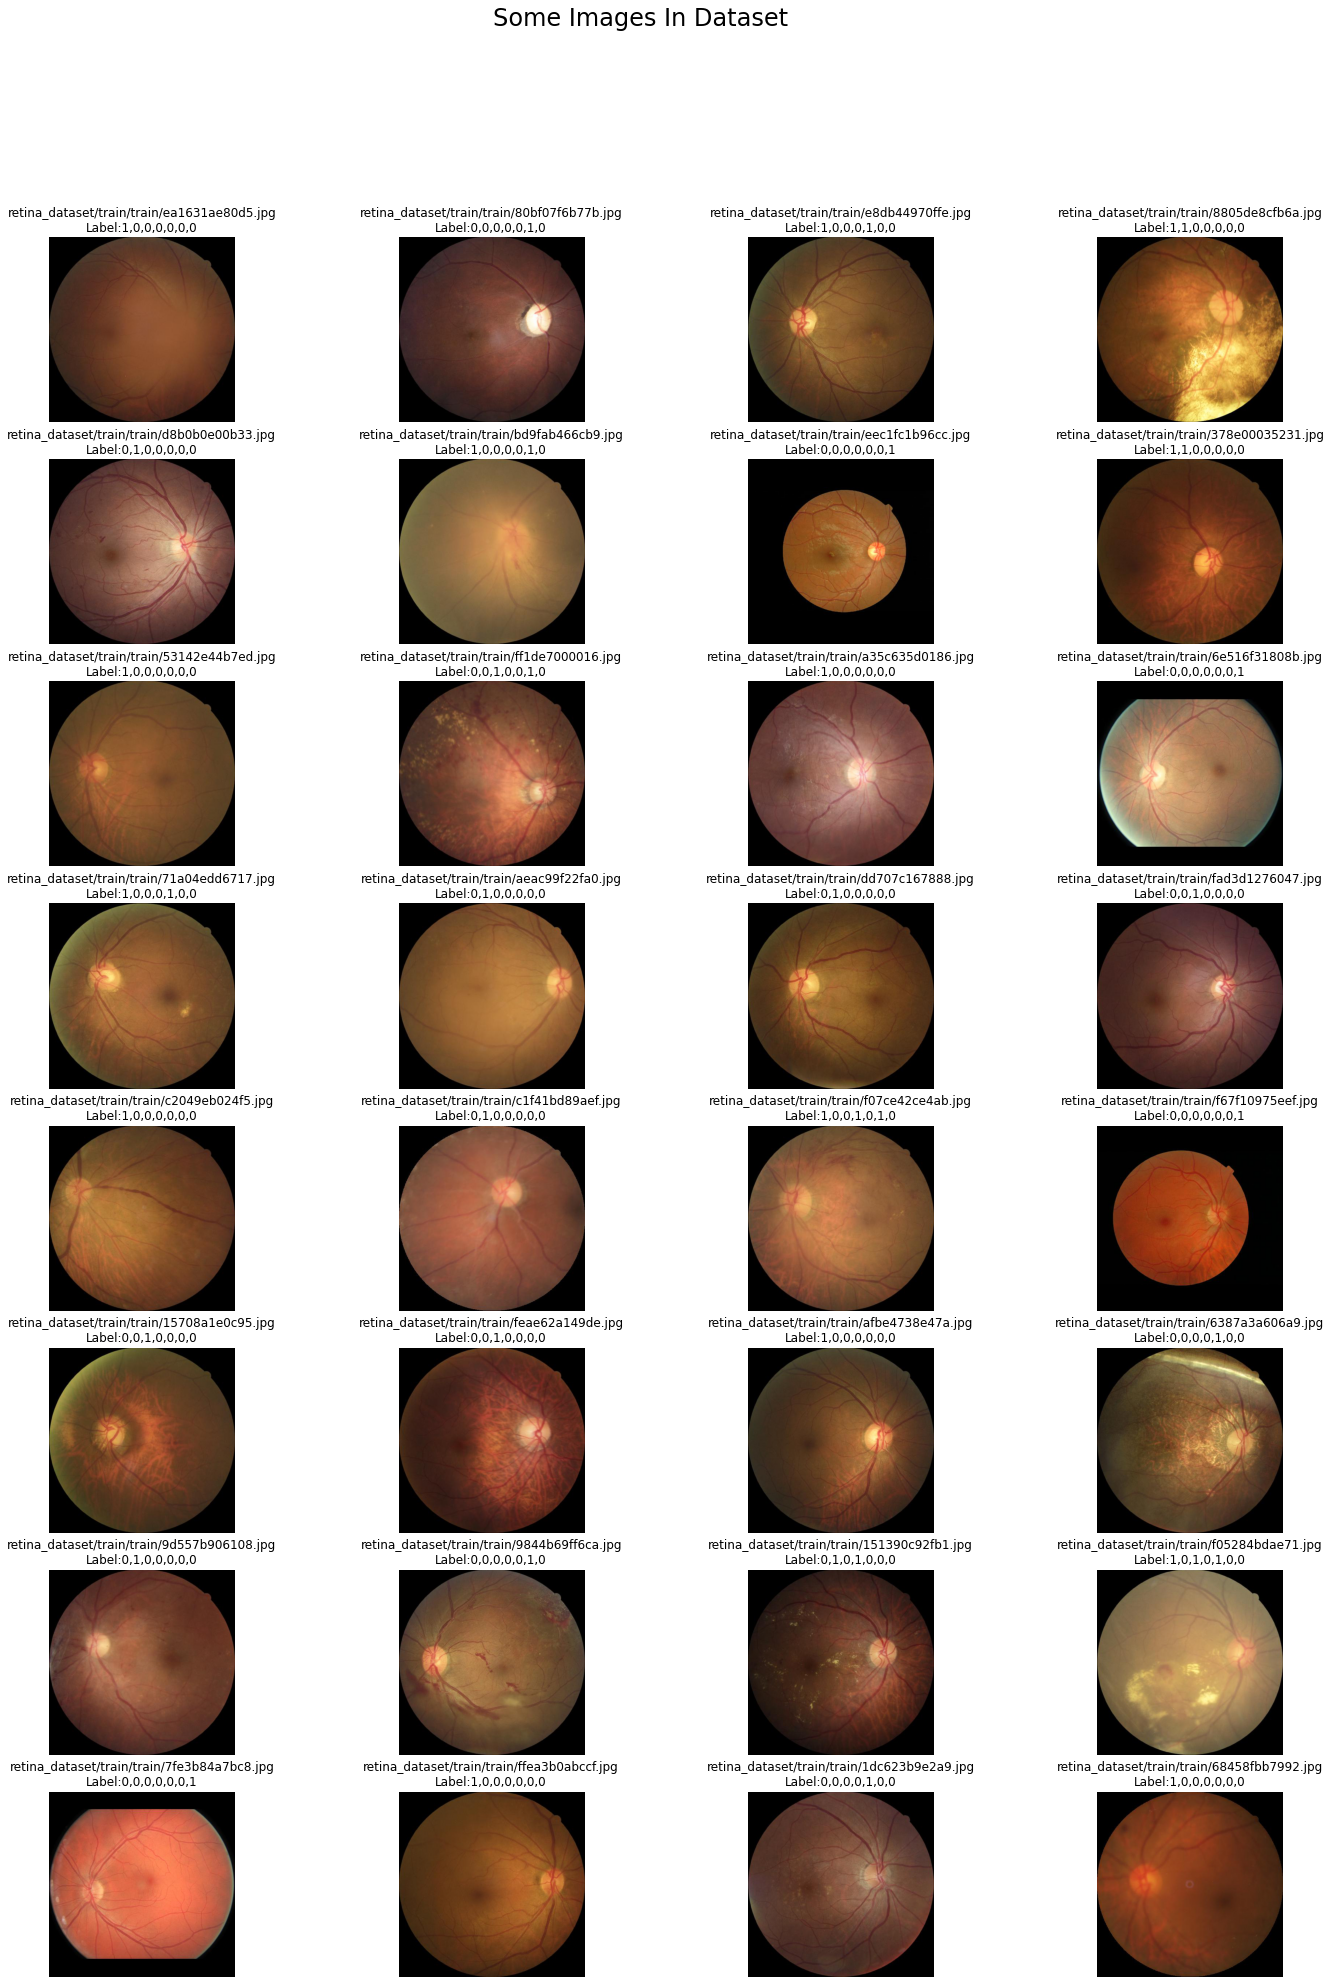

In [ ]:
#Create dataloader all dataset entries and show some examples
data_dataset = RetinaDataset('retina_dataset/train/train', data, (IMAGE_SIZE,IMAGE_SIZE), True)
data_dataloader = DataLoader(dataset=data_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)

#Let's check the size of data and label for each iteration
for images,labels,paths in data_dataloader:
  nums_img=images.shape[0]
  cols=4
  rows=nums_img//cols
  fig=plt.figure(figsize=(cols*6,rows*4))
  fig.suptitle("Some Images In Dataset ",fontsize=24)
  for i in np.arange(rows):
    for j in np.arange(cols):
      index=(i*cols)+j
      path=paths[index]
      img = Image.open(path).convert("RGB")
      name =path#name=os.path.basename(path)
      label=labels[index]
      title=name+'\nLabel:'+','.join([str(int(i.numpy())) for i in label])
      
      plt.subplot(rows,cols,index+1)
      plt.title(title)
      plt.axis('off')
      plt.imshow(img)
  plt.show()
  break

In [ ]:
#Create train dataset and train dataloader
train_dataset = RetinaDataset('retina_dataset/train/train', train_data, (IMAGE_SIZE,IMAGE_SIZE), True)
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)

#Let's check the size of data and label for each iteration
for image_batch,label_batch,_ in train_dataloader:
    print(image_batch.size())
    print(label_batch.size())
    break

torch.Size([8, 3, 299, 299])
torch.Size([8, 7])


In [ ]:
#Create val dataset and val dataloader
val_dataset = RetinaDataset('retina_dataset/train/train', val_data, (IMAGE_SIZE,IMAGE_SIZE), True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=None, num_workers=4, pin_memory=True)

#Let's check the size of data and label for each iteration
for image_batch,label_batch,_ in val_dataloader:
    print(image_batch.size())
    print(label_batch.size())
    break

torch.Size([8, 3, 299, 299])
torch.Size([8, 7])


#STEP 04: DEFINE RETINA MODEL

In this notebook, we will use Pytorch library to implement and train ResNet50 as a baseline model. With initial weights from ImageNet, we will retrain all layers for this problem.

In [ ]:
#Check GPU available
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

##Define retina model

In [ ]:
#Backbone
class Backbone(nn.Module): 
  def __init__(self, num_classes, is_trained=True):
    super().__init__()

    self.net = torchvision.models.inception_v3(pretrained=is_trained, aux_logits = False)
    
    classifier_input_size = self.net.fc.in_features
    self.net.fc = nn.Sequential(nn.Linear(classifier_input_size, num_classes), nn.Sigmoid())

  def forward(self, images):
      return self.net(images)

In [ ]:
class RetinaModel(nn.Module): 
  def __init__(self, num_classes):
    super().__init__()
    self.backbone = Backbone(num_classes,True)

  def forward(self, images):
      x=self.backbone(images)
      return x

In [ ]:
#Create model and get number of trainable parameters
model = RetinaModel(num_classes=len(LABELS)).to(device)
model

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth


RetinaModel(
  (backbone): Backbone(
    (net): Inception3(
      (Conv2d_1a_3x3): BasicConv2d(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      )
      (Conv2d_2a_3x3): BasicConv2d(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      )
      (Conv2d_2b_3x3): BasicConv2d(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      )
      (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (Conv2d_3b_1x1): BasicConv2d(
        (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, tr

In [ ]:
#Number of trainable parameters
sum(p.numel() for p in model.parameters() if p.requires_grad)

21799911

##Loss function, optimize and score metrics

In [ ]:
#Binary Cross Entropy
loss_criteria = nn.BCELoss()

# Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.999), eps=1e-8, weight_decay=1e-5)

# Learning rate will be reduced automatically during training
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = LEARNING_RATE_SCHEDULE_FACTOR, patience = LEARNING_RATE_SCHEDULE_PATIENCE, mode = 'max', verbose=True)

# Compute F1-score

def f1_score(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = np.sum(np.round(np.clip(y_true * y_pred, 0, 1)))
        possible_positives = np.sum(np.round(np.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + np.finfo(float).eps)
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = np.sum(np.round(np.clip(y_true * y_pred, 0, 1)))
        predicted_positives = np.sum(np.round(np.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + np.finfo(float).eps)
        return precision

    true_np = y_true.to("cpu").numpy()
    pred_np = y_pred.to("cpu").numpy()
    precision = precision(true_np, pred_np)
    recall = recall(true_np, pred_np)
    return 2*((precision*recall)/(precision+recall+np.finfo(float).eps))

#STEP 05: TRAINING PHARSE

In [ ]:
#Define training excution for each epoch 
def epoch_training(epoch, model, train_dataloader, device, loss_criteria, optimizer, mb):
  # Switch model to training mode
  model.train()
  training_loss = 0 # Storing sum of training losses

  # For each batch
  for batch, (images,labels,_) in enumerate(progress_bar(train_dataloader, parent=mb)):

    # Move X, Y  to device (GPU)
    images = images.to(device)
    labels = labels.to(device)

    # Clear previous gradient
    optimizer.zero_grad()

    # Feed forward the model
    pred = model(images)
    loss = loss_criteria(pred, labels)

    # Back propagation
    loss.backward()

    # Update parameters
    optimizer.step()

    # Update training loss after each batch
    training_loss += loss.item()

    mb.child.comment = f'Training loss {training_loss/(batch+1)}'

  del images,labels, loss
  if torch.cuda.is_available(): 
    torch.cuda.empty_cache()

  # return training loss
  return training_loss/len(train_dataloader)

In [ ]:
#Define training evaluation for each epoch
def evaluating(epoch, model, val_loader, device, loss_criteria, mb):
  # Switch model to evaluation mode
  model.eval()

  val_loss = 0                                   # Total loss of model on validation set
  out_pred = torch.FloatTensor().to(device)      # Tensor stores prediction values
  out_gt = torch.FloatTensor().to(device)        # Tensor stores groundtruth values

  with torch.no_grad(): # Turn off gradient
    # For each batch
    for step, (images, labels,_) in enumerate(progress_bar(val_loader, parent=mb)):
      # Move images, labels to device (GPU)
      images = images.to(device)
      labels = labels.to(device)

      # Update groundtruth values
      out_gt = torch.cat((out_gt,  labels), 0)

      # Feed forward the model
      ps = model(images)
      loss = loss_criteria(ps, labels)

      # Update prediction values
      out_pred = torch.cat((out_pred, ps), 0)

      # Update validation loss after each batch
      val_loss += loss
      mb.child.comment = f'Validation loss {val_loss/(step+1)}'

  # Clear memory
  del images, labels, loss
  if torch.cuda.is_available(): 
    torch.cuda.empty_cache()
  # return validation loss, and metric score
  return val_loss/len(val_loader), np.array(f1_score(out_gt, out_pred)).mean()

In [ ]:
#Fully training
def fulltraining(device,model,train_dataloader,val_dataloader,max_epochs,loss_criteria,optimizer,lr_scheduler):
  # Best AUROC value during training
  best_score = 0
  training_losses = []
  validation_losses = []
  validation_score = []


  # Config progress bar
  mb = master_bar(range(max_epochs))
  mb.names = ['Training loss', 'Validation loss', 'Validation F1-score']
  x = []

  nonimproved_epoch = 0
  start_time = time.time()

  # Training each epoch
  for epoch in mb:
    mb.main_bar.comment = f'Best F1 score: {best_score}'
    x.append(epoch)

    # Training
    train_loss = epoch_training(epoch, model, train_dataloader, device, loss_criteria, optimizer, mb)
    training_losses.append(train_loss)

    # Evaluating
    val_loss, new_score = evaluating(epoch, model, val_dataloader, device, loss_criteria, mb)
    validation_losses.append(val_loss)
    validation_score.append(new_score)

    mb.write('-Finish epoch {} | train loss: {:.4f} | val loss: {:.4f} | val f1 score: {:.4f}'.format(epoch,train_loss, val_loss, new_score))

    # Update learning rate
    lr_scheduler.step(new_score)

    # Update training chart
    mb.update_graph([[x, training_losses], [x, validation_losses], [x, validation_score]], [0,epoch+1], [0,1])

    # Save model
    if best_score < new_score:
        mb.write(f"Improve F1-Score from {best_score} to {new_score}")
        best_score = new_score
        nonimproved_epoch = 0
        #Save model if f1 score is improved
        torch.save({"model": model.state_dict(), 
                        "optimizer": optimizer.state_dict(), 
                        "best_score": best_score, 
                        "epoch": epoch, 
                        "lr_scheduler": lr_scheduler.state_dict()}, 'retina_epoch{}_score{:.5f}.pth'.format(epoch,new_score))
    else: 
        nonimproved_epoch += 1

    if nonimproved_epoch > 10:
        break
        print("Early stopping")
    if time.time() - start_time > TRAINING_TIME_OUT:
        break
        print("Out of time")

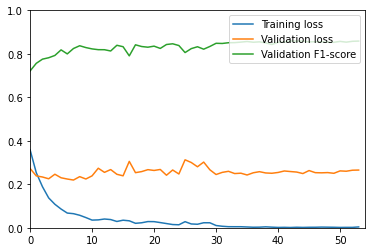

Epoch    30: reducing learning rate of group 0 to 1.0000e-05.
Epoch    42: reducing learning rate of group 0 to 1.0000e-06.
Epoch    49: reducing learning rate of group 0 to 1.0000e-07.
Training is done!


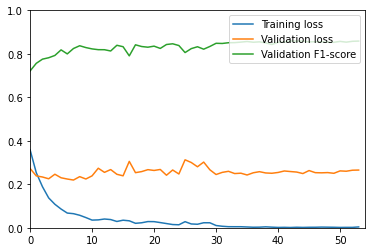

In [ ]:
#Run training 
fulltraining(device,model,train_dataloader,val_dataloader,MAX_EPOCHS,loss_criteria,optimizer,lr_scheduler)
print("Training is done!")

#STEP 06: TESTING PHARSE

##Read the test data

In [ ]:
test_df = pd.read_csv("retina_dataset/sample_submission.csv")
test_df.head()

,filename,predicted
0,e742d34a26d4.jpg,0 0
1,b193b6a6d68d.jpg,0 0
2,07e4191fa3a8.jpg,0 0
3,b1a911cb2e6c.jpg,0 0
4,d8ab9cda1b33.jpg,0 0


## Create test data generator

In [ ]:
#Create train dataset and train dataloader
test_dataset = RetinaDataset('retina_dataset/test/test', test_df, (IMAGE_SIZE,IMAGE_SIZE), True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=None, num_workers=4, pin_memory=True)

#Let's check the size of data and label for each iteration
for image_batch,label_batch,_ in test_dataloader:
    print(image_batch.size())
    print(label_batch.size())
    break

torch.Size([1, 3, 299, 299])
torch.Size([1, 1])


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load best model weights and switch to evaluation mode

In [ ]:
PATH_TRAINED_MODEL="/content/retina_epoch42_score0.85945.pth"    #place your saved checkpoint file here.
model = RetinaModel(num_classes=len(LABELS)).to(device)
model.load_state_dict(torch.load(PATH_TRAINED_MODEL)['model'])
model

RetinaModel(
  (backbone): Backbone(
    (net): Inception3(
      (Conv2d_1a_3x3): BasicConv2d(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      )
      (Conv2d_2a_3x3): BasicConv2d(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      )
      (Conv2d_2b_3x3): BasicConv2d(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      )
      (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (Conv2d_3b_1x1): BasicConv2d(
        (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, tr

##Predict test images

In [ ]:
from google.colab.patches import cv2_imshow

In [ ]:
def testing(model, test_loader, device):
  # Switch model to evaluation mode
  model.eval()
  out_pred = torch.FloatTensor().to(device)      # Tensor stores prediction values

  with torch.no_grad(): # Turn off gradient
    # For each batch
    for step, (images,_,_) in enumerate(progress_bar(test_dataloader)):
      # Move images to device (GPU)
      images = images.to(device)

      # Feed forward the model
      pred = model(images)
      # Update prediction values
      out_pred = torch.cat((out_pred, pred), 0)
      
    # Clear memory
    del images
    if torch.cuda.is_available(): 
      torch.cuda.empty_cache()
    return out_pred.to("cpu").numpy()

In [ ]:
out_pred = testing(model, test_dataloader, device)
out_pred=(out_pred > 0.5)*1
print("-Number images:",len(test_df.filename))
print("-Output shape:",out_pred.shape)

-Number images: 350
-Output shape: (350, 7)


In [ ]:
predicts_metadata={}
predicts_metadata['filename']=test_df.filename

for i in np.arange(len(LABELS)):
  predicts_metadata[INDEX_TO_LABEL[i]]=out_pred[:,i]
predicts_df = pd.DataFrame(predicts_metadata)
predicts_df

,filename,opacity,diabetic retinopathy,glaucoma,macular edema,macular degeneration,retinal vascular occlusion,normal
0,e742d34a26d4.jpg,0,0,0,0,0,0,1
1,b193b6a6d68d.jpg,1,0,0,0,1,0,0
2,07e4191fa3a8.jpg,1,0,0,0,0,0,0
3,b1a911cb2e6c.jpg,1,0,0,0,0,0,0
4,d8ab9cda1b33.jpg,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...
345,c3d744001f2f.jpg,0,0,0,0,0,0,1
346,f7b9fdd3d7e1.jpg,1,1,0,0,0,0,0
347,937b3f57bea7.jpg,0,1,0,0,0,0,0
348,4caffcaefb29.jpg,1,1,0,0,0,0,0



 /content/retina_dataset/test/test/e742d34a26d4.jpg


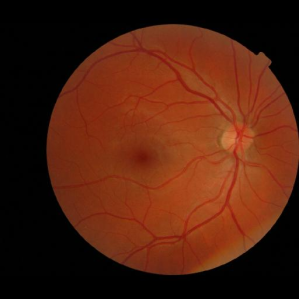

PREDICTED: 
normal 	

 /content/retina_dataset/test/test/b193b6a6d68d.jpg


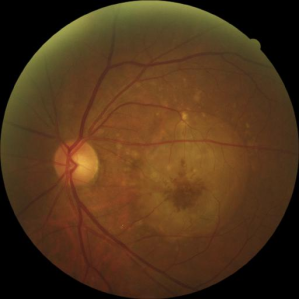

PREDICTED: 
opacity 	
macular degeneration 	

 /content/retina_dataset/test/test/07e4191fa3a8.jpg


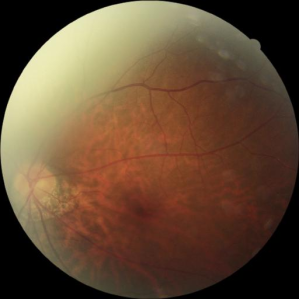

PREDICTED: 
opacity 	

 /content/retina_dataset/test/test/b1a911cb2e6c.jpg


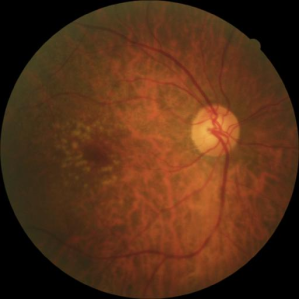

PREDICTED: 
opacity 	

 /content/retina_dataset/test/test/d8ab9cda1b33.jpg


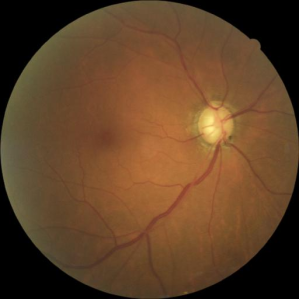

PREDICTED: 
opacity 	
glaucoma 	

 /content/retina_dataset/test/test/93a65c4bb12f.jpg


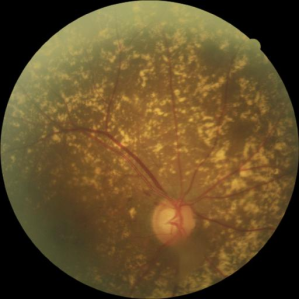

PREDICTED: 
macular degeneration 	

 /content/retina_dataset/test/test/da651785cb6f.jpg


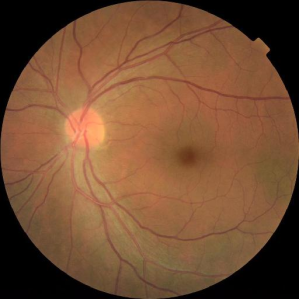

PREDICTED: 
normal 	

 /content/retina_dataset/test/test/c97cf1bb9dda.jpg


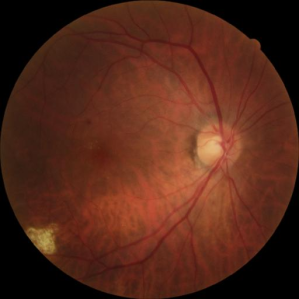

PREDICTED: 
diabetic retinopathy 	
macular edema 	

 /content/retina_dataset/test/test/77f285bd000a.jpg


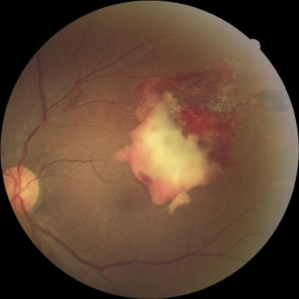

PREDICTED: 
retinal vascular occlusion 	

 /content/retina_dataset/test/test/dfb9dbfb57d3.jpg


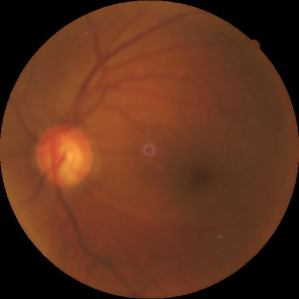

PREDICTED: 
glaucoma 	


In [ ]:
predicts_df['filename'][:10]
label = ['opacity',	'diabetic retinopathy',	'glaucoma'	,'macular edema',	'macular degeneration',	'retinal vascular occlusion',	'normal']
path = '/content/retina_dataset/test/test'
for i,img in enumerate(predicts_df['filename'][:10]):
  path_img = path + '/' + img
  print("\n",path_img)
  image = cv2.imread(path_img)
  image = cv2.resize(image,(299,299),  interpolation = cv2.INTER_AREA )
  cv2_imshow(image)
  print("PREDICTED: ")
  for ilabel in label:
    if predicts_df[ilabel][i] == 1:
      print(ilabel, "\t")
  